In [1]:
# Dependencies

import pandas as pd
import numpy as np
import seaborn as sns
import requests
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
# Reading in the csv data and creating a dataframe

births_df = pd.read_csv("2021_Data.csv")
births_df.head()

,dob_yy,dob_mm,dob_tt,bfacil,f_facility,bfacil3,mage_impflg,mage_repflg,mager,mager14,...,ca_downs,ca_disor,ca_hypo,f_ca_limb,f_ca_cleftlp,f_ca_cleft,f_ca_downs,f_ca_chrom,f_ca_hypos,no_congen
0,2021,1,636,1,1,1,NaN,NaN,22,8,...,N,N,N,1,1,1,1,1,1,1
1,2021,1,259,1,1,1,NaN,NaN,31,10,...,N,N,N,1,1,1,1,1,1,1
2,2021,1,223,1,1,1,NaN,NaN,29,9,...,N,N,N,1,1,1,1,1,1,1
3,2021,1,241,1,1,1,NaN,NaN,39,11,...,N,N,N,1,1,1,1,1,1,1
4,2021,1,503,1,1,1,NaN,NaN,20,8,...,N,N,N,1,1,1,1,1,1,1


# Data Cleaning

In [3]:
# Extract columns related to Prenatal Care + Payment Source

precare_births_df = births_df[["dob_yy", "dob_mm","bfacil", "mager", "precare", "previs", "wic", "pay_rec"]]
precare_births_df.head()

,dob_yy,dob_mm,bfacil,mager,precare,previs,wic,pay_rec
0,2021,1,1,22,3,99,Y,4
1,2021,1,1,31,99,99,N,4
2,2021,1,1,29,3,8,N,2
3,2021,1,1,39,2,10,N,1
4,2021,1,1,20,3,11,N,1


In [4]:
# Rename columns

precare_births_df = precare_births_df.rename(columns={
    "dob_yy":"Birth Year", 
    "dob_mm":"Birth Month", 
    "bfacil":"Birth Place", 
    "mager":"Mother's Age", 
    "precare": "Month Prenatal Care Began", 
    "previs": "Number of Prenatal Visits",
    "wic": "WIC",
    "pay_rec":"Payment Source",
})
precare_births_df.head()

,Birth Year,Birth Month,Birth Place,Mother's Age,Month Prenatal Care Began,Number of Prenatal Visits,WIC,Payment Source
0,2021,1,1,22,3,99,Y,4
1,2021,1,1,31,99,99,N,4
2,2021,1,1,29,3,8,N,2
3,2021,1,1,39,2,10,N,1
4,2021,1,1,20,3,11,N,1


In [5]:
# Filtering out any data that is unknown (this is represented by the values 9 and/or 99)

precare_births_df = precare_births_df[~precare_births_df.apply(lambda row: any(x in [9,99] for x in row), axis=1)]
precare_births_df.head()

,Birth Year,Birth Month,Birth Place,Mother's Age,Month Prenatal Care Began,Number of Prenatal Visits,WIC,Payment Source
2,2021,1,1,29,3,8,N,2
3,2021,1,1,39,2,10,N,1
4,2021,1,1,20,3,11,N,1
5,2021,1,1,29,3,7,N,2
6,2021,1,1,23,3,17,N,1


In [6]:
# Convert columns to strings
precare_births_df["Birth Place"] = precare_births_df["Birth Place"].astype(str)
precare_births_df["Payment Source"] = precare_births_df["Payment Source"].astype(str)
precare_births_df["Birth Month"] = precare_births_df["Birth Month"].astype(str)

# Replace values
precare_births_df["Birth Place"] = precare_births_df["Birth Place"].replace({"1": "Hospital", "2": "Freestanding Birth Center", "3": "Home (intended)", "4": "Home (unintended)", "5": "Home (intent unknown)", "6": "Clinic/Doctor's Office", "7": "Other"})
precare_births_df["Payment Source"] = precare_births_df["Payment Source"].replace({"1": "Medicaid", "2": "Private Insurance", "3": "Self-Pay", "4": "Other", "9": "Unknown"})
precare_births_df["Birth Month"] = precare_births_df["Birth Month"].replace({"1": "Jan", "2": "Feb", "3": "Mar", "4": "Apr", "5": "May", "6": "Jun", "7": "Jul", "8": "Aug", "9": "Sep", "10":"Oct", "11":"Nov", "12":"Dec"})


# Display updated dataframe
precare_births_df.head()

,Birth Year,Birth Month,Birth Place,Mother's Age,Month Prenatal Care Began,Number of Prenatal Visits,WIC,Payment Source
2,2021,Jan,Hospital,29,3,8,N,Private Insurance
3,2021,Jan,Hospital,39,2,10,N,Medicaid
4,2021,Jan,Hospital,20,3,11,N,Medicaid
5,2021,Jan,Hospital,29,3,7,N,Private Insurance
6,2021,Jan,Hospital,23,3,17,N,Medicaid


In [7]:
for column in precare_births_df.columns:
    unique_values = precare_births_df[column].unique()
    print(f"{column}: {unique_values}")


Birth Year: [2021]
Birth Month: ['Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Oct' 'Nov' 'Dec']
Birth Place: ['Hospital' 'Freestanding Birth Center' 'Home (intended)'
 "Clinic/Doctor's Office" 'Home (intent unknown)' 'Home (unintended)'
 'Other']
Mother's Age: [29 39 20 23 34 19 25 24 28 32 37 27 41 36 38 33 21 31 22 30 35 26 48 40
 18 16 42 17 15 44 43 14 45 47 46 13 12 50 49]
Month Prenatal Care Began: [ 3  2  5  1  6  7  4  8  0 10]
Number of Prenatal Visits: [ 8 10 11  7 17  5 19  3 12  4 15 14 25  2 13  6 27 18 16  1 22 20 21  0
 26 24 28 35 29 23 39 34 46 41 33 30 32 31 38 42 37]
WIC: ['N' 'Y' 'U']
Payment Source: ['Private Insurance' 'Medicaid' 'Other' 'Self-Pay']


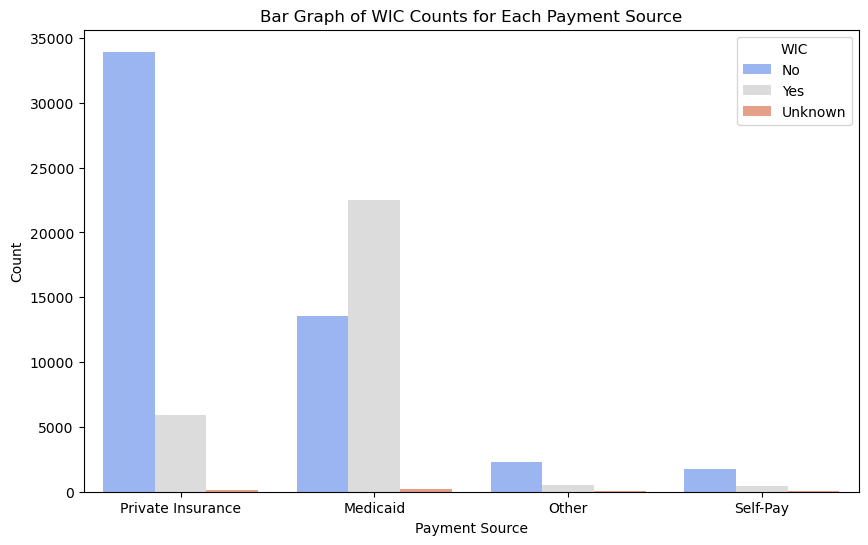

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 'Y', 'N', 'U' in 'WIC' column with categorical values
precare_births_df['WIC'] = precare_births_df['WIC'].replace({'Y': 'Yes', 'N': 'No', 'U': 'Unknown'})

# Create a bar graph
plt.figure(figsize=(10, 6))
sns.countplot(x='Payment Source', hue='WIC', data=precare_births_df, palette='coolwarm')
plt.title('Bar Graph of WIC Counts for Each Payment Source')
plt.xlabel('Payment Source')
plt.ylabel('Count')
plt.legend(title='WIC')
plt.savefig('wic_payment_source_bar_graph.png')
plt.show()


In [13]:
# Convert 'Payment Source' and 'WIC' columns to string type
precare_births_df['Payment Source'] = precare_births_df['Payment Source'].astype(str)
precare_births_df['WIC'] = precare_births_df['WIC'].astype(str)

# Calculate the correlation coefficient
correlation_coefficient = precare_births_df['Payment Source'].corr(precare_births_df['WIC'])

# Display the correlation coefficient
print(f"Correlation coefficient between 'Payment Source' and 'WIC': {correlation_coefficient}")


ValueError: could not convert string to float: 'Private Insurance'

In [17]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the DataFrame to avoid modifying the original data
encoded_df = precare_births_df.copy()

# Apply label encoding to 'Payment Source' and 'WIC' columns
label_encoder = LabelEncoder()

encoded_df['Payment Source'] = label_encoder.fit_transform(encoded_df['Payment Source'])
encoded_df['WIC'] = label_encoder.fit_transform(encoded_df['WIC'])

# Calculate the correlation coefficient
correlation_coefficient = encoded_df['WIC'].corr(encoded_df['Payment Source'])

# Display the correlation coefficient
print(f"Correlation coefficient between 'Payment Source' and 'WIC': {correlation_coefficient}")


Correlation coefficient between 'Payment Source' and 'WIC': -0.47003503757439


In [18]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table for 'WIC' and 'Payment Source'
contingency_table = pd.crosstab(precare_births_df['WIC'], precare_births_df['Payment Source'])

# Calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Calculate Cramér's V for 'WIC' and 'Payment Source'
cramers_v_value = cramers_v(contingency_table)

print(f"Cramér's V value: {cramers_v_value}")


Cramér's V value: 0.3433964649754207
